In [1]:
#Import required packages
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#Helper functions
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'


In [3]:
#Toy model with generated architecture
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

In [4]:
#Define search space
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 0.001, 10), hp.uniform('k1_ur', 1E-7, 1E-3)], [2., hp.uniform('theta2_ur', 0.001, 10), hp.uniform('k2_ur', 1E-7, 1E-3)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 0.001, 10), hp.uniform('k1_nc', 1E-7, 1E-3)], [2., hp.uniform('theta2_nc', 0.001, 10), hp.uniform('k2_nc', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 0.001, 10), hp.uniform('k1_dc', 1E-7, 1E-3)], [2., hp.uniform('theta2_dc', 0.001, 10), hp.uniform('k2_dc', 1E-7, 1E-3)]])])
    

In [27]:
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    alpha1_setting = 1E-5
    alpha2_setting = 1E-2

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E4, 100) 
        y0 = np.array([2290., 0., 0., 0., 0., 0.])

        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
        ode_solver = ode('cvode', toy_model, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1_setting, alpha2=alpha2_setting)

        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    landscape = pd.DataFrame({'Circuit':circuits, 'Loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    landscape['Circuit'] = [name_converter(c) for c in landscape.Circuit]
    return landscape, best

In [35]:
max_iters = 500
landscape = run_hyperopt(max_iters)
landscape, best = landscape

100%|██████████| 500/500 [00:26<00:00, 18.64trial/s, best loss: 0.06480849943468876]


In [36]:
def get_best_loss_trace(landscape):
    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.Loss[i] < best_loss:
            best_loss = landscape.Loss[i]
            best_circuit = landscape.Circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    return best_losses, best_losses_circuits

In [37]:
best_loss_landscape = pd.DataFrame(columns=['Circuit', 'Loss', 'k1', 'k2', 'theta1', 'theta2', 'Best Loss', 'Best Loss Architecture'])
start_index = 0
min_losses, min_archs = [[], []]
for i in range(num_replicates):
    #landscape = replicate_landscapes.iloc[start_index:start_index+max_iters].reset_index(drop=True)
    best_losses, best_loss_circuits = get_best_loss_trace(landscape)
    landscape['Best Loss'] = best_losses
    landscape['Best Loss Architecture'] = best_loss_circuits
    best_loss_landscape = pd.concat([best_loss_landscape, landscape])
    start_index = start_index+max_iters+1
    min_archs.append(best_loss_circuits[-1])
    min_losses.append(best_losses[-1])
best_loss_landscape = best_loss_landscape.reset_index(drop=True)

In [62]:
orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'No Control': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}

Text(0.5, 0, 'Number of Iterations')

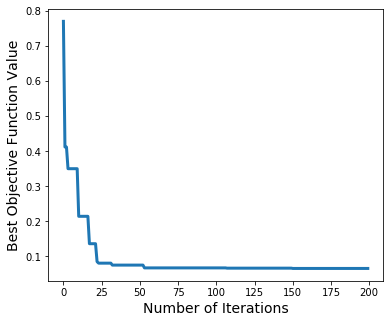

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(best_loss_landscape['Best Loss'][:200], linewidth=3)
ax.set_ylabel('Best Objective Function Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


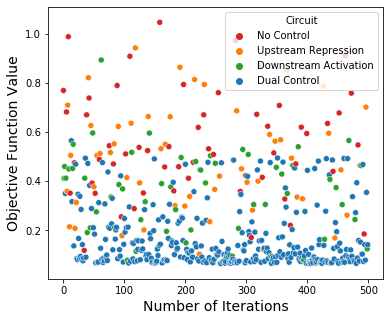

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_ylabel('Objective Function Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'Loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


[None, None]

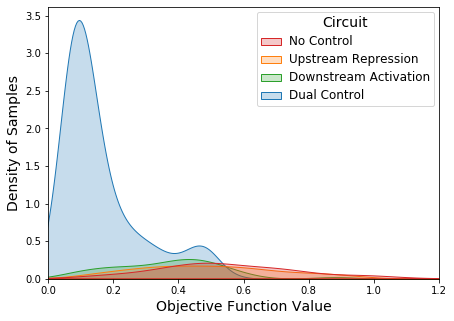

In [70]:
#Distribution of losses sampled from each architecture, 10 replicates
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.kdeplot( x='Loss', hue='Circuit', data=landscape, ax=ax, bw=0.4, fill=True, hue_order=orders, palette=palette)
ax.set_xlim([0, 1.2])
ax.set_ylabel('Density of Samples', fontsize=14)
ax.set_xlabel('Objective Function Value', fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title


In [72]:
#Bar plot splitting trajectory into quintiles

orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'No Control': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}



quantiles10 = np.array_split(landscape, 5)
dc = []
da = []
nc = []
ur = []
for i in range(5):
    nums = quantiles10[i].groupby('Circuit').count().Loss
    percents = 100*nums/(len(landscape)/5)
    dc.append(percents['Dual Control'])
    da.append(percents['Dual Control']+percents['Downstream Activation'])
    ur.append(percents['Dual Control']+percents['Downstream Activation']+percents['Upstream Repression'])
    nc.append(percents['Dual Control']+percents['Downstream Activation']+percents['Upstream Repression']+percents['No Control'])
data = pd.DataFrame({'Quintile': range(1,6), 'Downstream Activation': da, 'Dual Control': dc, 'Upstream Repression': ur, 'No Control': nc})


#plt.savefig('Gamma90_barplot.png')

Text(0.5, 0, 'Epoch Quintile')

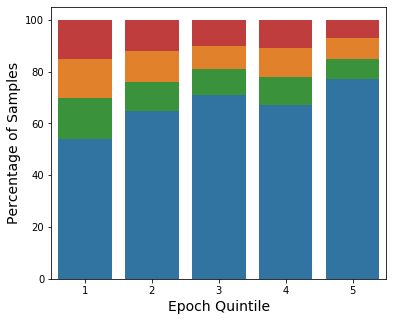

<Figure size 648x360 with 0 Axes>

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.figure(figsize=(9, 5))
bar4 = sns.barplot(x="Quintile",  y="No Control", data=data, color=palette['No Control'], ax=ax)
bar3 = sns.barplot(x="Quintile",  y="Upstream Repression", data=data, color=palette['Upstream Repression'], ax=ax)
bar2 = sns.barplot(x="Quintile",  y="Downstream Activation", data=data, color=palette['Downstream Activation'], ax=ax)
bar1 = sns.barplot(x="Quintile",  y="Dual Control", data=data, color=palette['Dual Control'], ax=ax)
ax.set_ylabel('Percentage of Samples', fontsize=14)
ax.set_xlabel('Epoch Quintile', fontsize=14)

In [75]:
landscape = pd.read_csv('ga_testcase.csv')

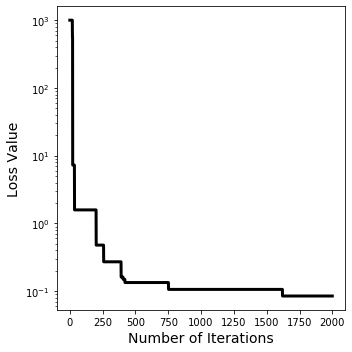

In [87]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

ax = axs
ax.plot(landscape.best_losses, 'k-', linewidth=3)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)
#sns.scatterplot(range(len(landscape)), 'best_losses', hue='Best_Loss_Circuit', data=landscape,  ax=ax, hue_order=orders, palette=palette)
fig.tight_layout()

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


(0.1, 1000000000.0)

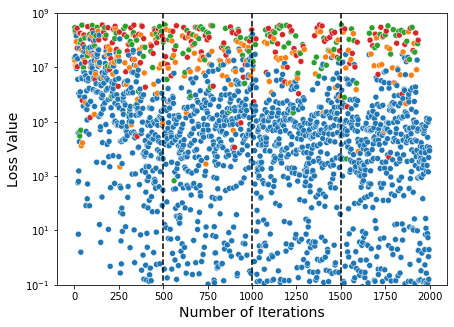

In [101]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
ax = axs
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False)
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(1500, 0, 10E9, linestyles='dashed')
ax.vlines(1000, 0, 10E9, linestyles='dashed')
ax.set_ylim([10E-2, 10E8])

([<matplotlib.patches.Wedge at 0x7f7c8a6ff9a0>,
 [Text(1.085354540119397, 0.17890087267034988, ''),
  Text(-1.086457180293535, 0.1720778759417423, ''),
  Text(0.9769501310397409, -0.5055377745148558, ''),
  Text(1.0864571863351944, -0.1720778377961938, '')])

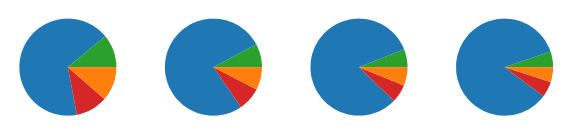

In [129]:
quarter1 = (landscape.iloc[0:500].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter2 = (landscape.iloc[500:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter3 = (landscape.iloc[1000:1500].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter4 = (landscape.iloc[1500:2000].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
colors = ['tab:green', 'tab:blue', (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'tab:orange']

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].pie(quarter1.loss, colors=colors)
axs[1].pie(quarter2.loss, colors=colors)
axs[2].pie(quarter3.loss, colors=colors)
axs[3].pie(quarter4.loss, colors=colors)

In [161]:
da = pd.read_csv('../continuous_hyperopt/da_background.csv')
da['circuit'] = 'Downstream Activation'
dc = pd.read_csv('../continuous_hyperopt/dc_background.csv')
dc['circuit'] = 'Dual Control'
nc = pd.read_csv('../continuous_hyperopt/nc_background.csv')
nc['circuit'] = 'No Control'
ur = pd.read_csv('../continuous_hyperopt/ur_background.csv')
ur['circuit'] = 'Upstream Repression'
landscape = pd.concat([da, dc, nc, ur])

Text(0, 0.5, 'Circuit')

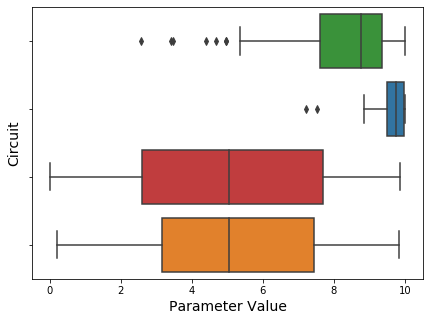

In [168]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
ax = axs
sns.boxplot(data=landscape, x='theta2', y='circuit',hue_order=orders, palette=palette)
ax.set_yticklabels([])
ax.set_xlabel('Parameter Value', fontsize=14)
ax.set_ylabel('Circuit', fontsize=14)
